In [1]:
%matplotlib inline

In [2]:
import shapely as sh
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch
import IPython 
import numpy as np
from matplotlib import pyplot

In [3]:
#coordinates are taken from
#https://desi.lbl.gov/trac/browser/code/focalplane/positioner_control/trunk/anticollision/pos_geometry.m?rev=1660

In [4]:
#general paramaters
ferrule_radius = 1.250/2
R1 = 3.000 # distance from central axis to eccentric axis
R2 = 3.000 # distance from eccentric axis to ferrule axis
Ei = 6.800 # inner clear rotation envelope
Eo = 9.990 # outer clear rotation envelope

In [9]:
lower_ferrule_pos = np.array(((0.387, 0.990), (0.967,0.410), (0.967, -0.410), (0.387, -0.990), (-0.649, -0.990), 
                    (-1.000, -0.639), (-1.000, 0.639), (-0.649, 0.990)))
lower_ferrule_pos[:,0]=lower_ferrule_pos[:,0]+R1

In [10]:
upper_ferrule_pos=np.array(((0.387, -0.990), (0.967, -0.410), (0.967,0.410), (0.387,0.990), (-2.235,0.990), 
                   (-2.668, 1.240), (-3.514, 1.240), (-4.240,0.514), (-4.240,-0.514), (-3.682,-1.072), 
                  (-2.994,-1.339), (-2.944,-1.922), (-2.688, -2.015 ), (-1.981,-1.757 ), (-1.844, -0.990)))
upper_ferrule_pos[:,0]=upper_ferrule_pos[:,0]+R1

In [11]:
central_axis_body = np.array((( 4.358 , -2.500), (5.095,-0.474),(5.095,0.605),(4.348,1.792), 
                    (3.000,2.180), (1.652, 1.792), (0.905, 0.605), (0.905 ,-0.356), 
                    (1.759, -2.792), (2.771, -2.500)))
central_poly = Polygon(central_axis_body)

In [12]:
Ei_circ_resn  = 32
Eo_circ_resn  = 32;
Eo = 9.990 #clear rotational envelope
tmp = np.zeros((Eo_circ_resn,2))
tmp[:,0] = Eo/2*np.cos(np.linspace(0,2*np.pi,Eo_circ_resn))
tmp[:,1] = Eo/2*np.sin(np.linspace(0,2*np.pi,Eo_circ_resn))
Eo_poly = Polygon(tmp);
ctr_arm_poly = Polygon(((0,0),(R1,0), (0,0))) #central arm polygon

In [13]:
def add_plot_positioner(up_shape, central_shape, lower_shape, x_offset=0.0, y_offset=0.0, ax=None):
    tmp_up_shape  = up_shape.copy()
    tmp_central_shape  = central_shape.copy()
    tmp_lower_shape  = lower_shape.copy()

    tmp_up_shape[:,0] = tmp_up_shape[:,0] + x_offset
    tmp_central_shape[:,0] = tmp_central_shape[:,0] + x_offset
    tmp_lower_shape[:,0] = tmp_lower_shape[:,0] + x_offset
    
    tmp_up_shape[:,1] = tmp_up_shape[:,1] + y_offset
    tmp_central_shape[:,1] = tmp_central_shape[:,1] + y_offset
    tmp_lower_shape[:,1] = tmp_lower_shape[:,1] + y_offset
    
    up_poly = Polygon(tmp_up_shape)
    central_poly= Polygon(tmp_central_shape)
    low_poly= Polygon(tmp_lower_shape)

    patch_u = PolygonPatch(up_poly, facecolor='yellow', edgecolor='yellow', alpha=0.5, zorder=2)
    patch_c = PolygonPatch(central_poly, facecolor='blue', edgecolor='blue', alpha=0.5, zorder=2)
    patch_l = PolygonPatch(low_poly, facecolor='red', edgecolor='red', alpha=0.5, zorder=2)

    patch_outer = PolygonPatch(Eo_poly, facecolor='white', edgecolor='black', alpha=0.2, zorder=2)
    patch_ctr_arm = PolygonPatch(ctr_arm_poly, facecolor='white', edgecolor='black', alpha=0.2, zorder=2)

    ax.add_patch(patch_c)
    ax.add_patch(patch_l)
    ax.add_patch(patch_u)
    ax.add_patch(patch_outer)
    ax.add_patch(patch_ctr_arm)

In [15]:
def rot_displ_shape(shape_coords, angle=0.0, radius=0.0):
    tmp = shape_coords.copy()
    tmp[:,0] = shape_coords[:,0]*np.cos(np.deg2rad(angle)) - shape_coords[:,1]*np.sin(np.deg2rad(angle))
    tmp[:,1] = shape_coords[:,0]*np.sin(np.deg2rad(angle)) + shape_coords[:,1]*np.cos(np.deg2rad(angle))
    tmp[:,0] = tmp[:,0] + radius*np.cos(np.deg2rad(angle))
    tmp[:,1] = tmp[:,1] + radius*np.sin(np.deg2rad(angle))
    return tmp

In [20]:
def position_T_P(upper_pos, central_pos, low_pos, T=0, P=0, R=0):
    #first rotate phi
    current_up_pos = rot_displ_shape(upper_pos, angle=P) 
    current_low_pos = rot_displ_shape(low_pos, angle=P)
    #offset the central axis 
    current_up_pos = rot_displ_shape(current_up_pos, angle=0, radius=R) 
    current_low_pos = rot_displ_shape(current_low_pos, angle=0, radius=R)
    #now rotathe theta
    current_up_pos = rot_displ_shape(current_up_pos, angle=T) 
    current_low_pos = rot_displ_shape(current_low_pos, angle=T)
    current_central_pos = rot_displ_shape(central_pos, angle=T)
    return current_up_pos, current_central_pos, current_low_pos

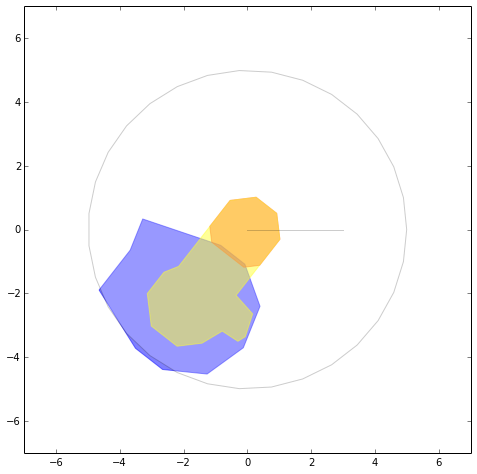

In [22]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
T = -128.0 #theta
P = +180.0 #phi
up, central, low = position_T_P(upper_ferrule_pos, central_axis_body, lower_ferrule_pos, T=T, P=P, R=R1)
add_plot_positioner(up, central, low, ax=ax)

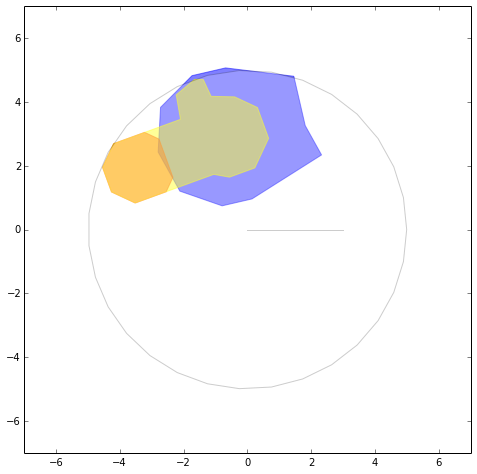

In [23]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
T = 103.0 #theta
P = 97.0 #phi
up, central, low = position_T_P(upper_ferrule_pos, central_axis_body, lower_ferrule_pos, T=T, P=P, R=R1)
add_plot_positioner(up, central, low, ax=ax)